In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
covidtotals = pd.read_csv('./data/covidtotalswithmissings.csv')

In [3]:
covidtotals.columns

Index(['iso_code', 'lastdate', 'location', 'total_cases', 'total_deaths',
       'total_cases_pm', 'total_deaths_pm', 'population', 'pop_density',
       'median_age', 'gdp_per_capita', 'hosp_beds'],
      dtype='object')

In [4]:
covidtotals.head()

,iso_code,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
0,AFG,2020-06-01,Afghanistan,15205,257,390.589,6.602,38928341.0,54.422,18.6,1803.987,0.50
1,ALB,2020-06-01,Albania,1137,33,395.093,11.467,2877800.0,104.871,38.0,11803.431,2.89
2,DZA,2020-06-01,Algeria,9394,653,214.225,14.891,43851043.0,17.348,29.1,13913.839,1.90
3,AND,2020-06-01,Andorra,764,51,9888.048,660.066,77265.0,163.755,NaN,NaN,NaN
4,AGO,2020-06-01,Angola,86,4,2.617,0.122,32866268.0,23.890,16.8,5819.495,NaN


In [5]:
totvars = ['location', 'total_cases', 'total_deaths',
       'total_cases_pm', 'total_deaths_pm']

In [6]:
demovars = ['population', 'pop_density',
       'median_age', 'gdp_per_capita', 'hosp_beds']

# 누락값
## 인구통계변수 누락값 확인

In [7]:
#국가별로 누락된 인구통계변수 개수 합산(행 방향) >> 5개 변수중 3개 누락 국가가 10개, 4개 누락 국가가 8개
demovarsmisscnt = covidtotals[demovars].isnull().sum(axis = 1)
demovarsmisscnt.value_counts()

0    156
1     24
2     12
3     10
4      8
dtype: int64

In [41]:
demovarsmisscnt

0      0
1      0
2      0
3      3
4      1
      ..
205    0
206    3
207    0
208    0
209    0
Length: 210, dtype: int64

In [8]:
#인구통계열 누락데이터 확인(열 방향)
covidtotals[demovars].isnull().sum(axis = 0)

population         0
pop_density       12
median_age        24
gdp_per_capita    28
hosp_beds         46
dtype: int64

In [9]:
demovarsmisscnt

0      0
1      0
2      0
3      3
4      1
      ..
205    0
206    3
207    0
208    0
209    0
Length: 210, dtype: int64

### 📍index alignment & bool indexing 응용
- 인덱스 값끼리 연산
- 시리즈를 이용해 누락값이 3개 이상인 국가 선별

In [10]:
# 인구통계 데이터 세 개 이상 누락된 국가 나열 >> 인덱스 얼라인먼트 사용
covidtotals.loc[demovarsmisscnt >= 3, ['location', 'iso_code']+demovars].head(5).T

,3,5,24,28,64
location,Andorra,Anguilla,Bonaire Sint Eustatius and Saba,British Virgin Islands,Faeroe Islands
iso_code,AND,AIA,BES,VGB,FRO
population,77265.0,15002.0,26221.0,30237.0,48865.0
pop_density,163.755,NaN,NaN,207.973,35.308
median_age,NaN,NaN,NaN,NaN,NaN
gdp_per_capita,NaN,NaN,NaN,NaN,NaN
hosp_beds,NaN,NaN,NaN,NaN,NaN


In [11]:
type(demovarsmisscnt)

pandas.core.series.Series

## 코로나19 데이터 누락값 확인

In [12]:
# 코로나 데이터에서 누락값 확인 >> 1건(국가)
covidtotals[totvars].isnull().sum(axis = 0)

location           0
total_cases        0
total_deaths       0
total_cases_pm     1
total_deaths_pm    1
dtype: int64

In [13]:
totvarsmisscnt = covidtotals[totvars].isnull().sum(axis = 1)
totvarsmisscnt.value_counts()

0    209
2      1
dtype: int64

In [14]:
# 홍콩 데이터 누락 확인
covidtotals.loc[totvarsmisscnt > 0].T

,87
iso_code,HKG
lastdate,2020-05-26
location,Hong Kong
total_cases,0
total_deaths,0
total_cases_pm,NaN
total_deaths_pm,NaN
population,7496988.0
pop_density,7039.714
median_age,44.8


In [15]:
# 누락 데이터 채우기(fillna)
covidtotals.total_cases_pm.fillna(covidtotals.total_cases/(covidtotals.population/1000000), inplace = True)
covidtotals.total_deaths_pm.fillna(covidtotals.total_deaths/(covidtotals.population/1000000), inplace = True)

In [16]:
covidtotals[totvars].isnull().sum(axis = 0)

location           0
total_cases        0
total_deaths       0
total_cases_pm     0
total_deaths_pm    0
dtype: int64

# 이상값
- 값이 예상대로인지 아닌지 가정을 할 때 변수 분포를 근거로 삼음
- 이상값 식별을 위해 변수의 분포를 먼저 확인해야 함
- 👉 기본적으로 **무엇이 이상값을 구성하는가에 대한 감각은 정규분포를 가정으로 빚어짐**

In [17]:
import statsmodels.api as sm
import scipy.stats as scistat

In [18]:
covidtotals = pd.read_csv('./data/covidtotals.csv')

In [19]:
covidtotals.head()

,iso_code,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
0,AFG,2020-06-01,Afghanistan,15205,257,390.589,6.602,38928341.0,54.422,18.6,1803.987,0.50
1,ALB,2020-06-01,Albania,1137,33,395.093,11.467,2877800.0,104.871,38.0,11803.431,2.89
2,DZA,2020-06-01,Algeria,9394,653,214.225,14.891,43851043.0,17.348,29.1,13913.839,1.90
3,AND,2020-06-01,Andorra,764,51,9888.048,660.066,77265.0,163.755,NaN,NaN,NaN
4,AGO,2020-06-01,Angola,86,4,2.617,0.122,32866268.0,23.890,16.8,5819.495,NaN


In [20]:
covidtotals.set_index('iso_code', inplace = True)

In [21]:
covidtotalsonly = covidtotals.loc[:, totvars]
covidtotalsonly.describe()

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
count,2.100000e+02,210.000000,209.000000,209.000000
mean,2.921614e+04,1770.714286,1361.842909,55.925440
std,1.363978e+05,8705.565857,2629.894101,145.081876
min,0.000000e+00,0.000000,0.894000,0.000000
25%,1.757500e+02,4.000000,96.785000,0.893000
50%,1.242500e+03,25.500000,281.997000,6.214000
75%,1.011700e+04,241.250000,1803.318000,32.158000
max,1.790191e+06,104383.000000,19771.348000,1237.551000


### 백분위수 / 왜도와 첨도 확인

In [22]:
covidtotalsonly.quantile(np.arange(0.0, 1.1, 0.1))

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
0.0,0.0,0.0,0.8940,0.0000
0.1,22.9,0.0,18.4870,0.0000
0.2,105.2,2.0,56.7386,0.4008
0.3,302.0,6.7,118.2282,1.7348
0.4,762.0,12.0,214.9182,3.9734
0.5,1242.5,25.5,281.9970,6.2140
0.6,2514.6,54.6,546.0534,12.5644
0.7,6959.8,137.2,1074.0324,26.0638
0.8,16847.2,323.2,2208.7374,50.2896
0.9,46513.1,1616.9,3771.9956,139.5290


In [23]:
covidtotalsonly.skew()

total_cases        10.804275
total_deaths        8.929816
total_cases_pm      4.387402
total_deaths_pm     4.663124
dtype: float64

In [24]:
covidtotalsonly.kurt()

total_cases        134.979577
total_deaths        95.737841
total_cases_pm      25.138915
total_deaths_pm     27.105135
dtype: float64

### 정규성 검정
- scipy 라이브러리 >> 샤피로 윌크 검정

In [25]:
def testnorm(var, df):
    stat, p = scistat.shapiro(df[var])
    return p

testnorm('total_cases', covidtotalsonly)

3.753789128593843e-29

In [26]:
testnorm('total_deaths', covidtotalsonly)

4.3427896631016077e-29

In [27]:
testnorm('total_cases_pm', covidtotalsonly)

1.0

In [28]:
testnorm('total_deaths_pm', covidtotalsonly)

1.0

- qq plot(정규 분위수-분위수 그림)

<function matplotlib.pyplot.show(close=None, block=None)>

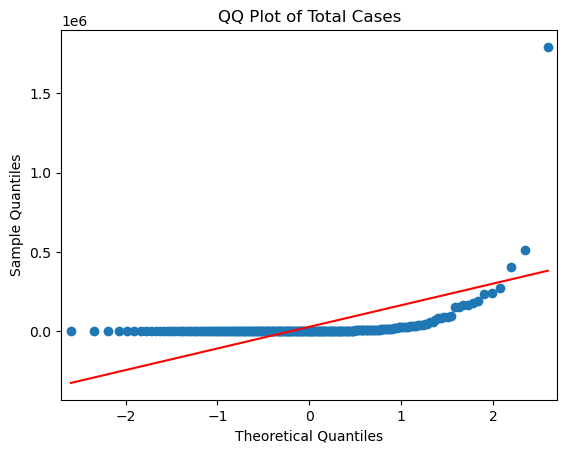

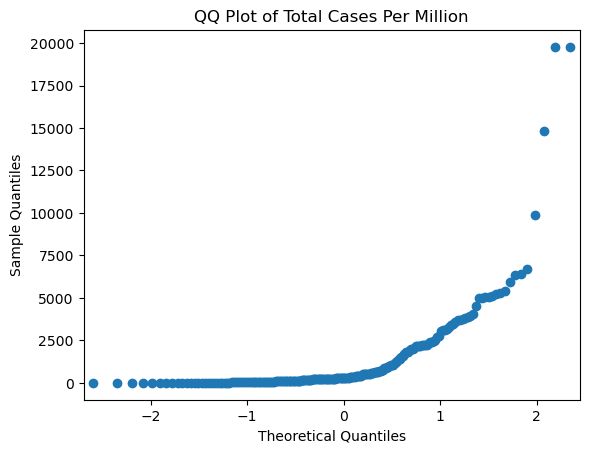

In [29]:
sm.qqplot(covidtotalsonly[['total_cases']].sort_values(['total_cases']), line = 's')
plt.title('QQ Plot of Total Cases')

sm.qqplot(covidtotalsonly[['total_cases_pm']].sort_values(['total_cases_pm']), line = 's')
plt.title('QQ Plot of Total Cases Per Million')
plt.show

- 결과 해석 : 두 변수 모두 정규분포와 크게 다르게 나타남

### 이상값 범위(IQR)

In [30]:
thirdq, firstq = covidtotalsonly.total_cases.quantile(0.75), covidtotalsonly.total_cases.quantile(0.25)
interquantilerange = 1.5 * (thirdq - firstq)
print(interquantilerange)

outlierhigh, outlierlow = interquantilerange + thirdq, firstq - interquantilerange
print(outlierlow, outlierhigh, sep = ' <--> ')

14911.875
-14736.125 <--> 25028.875


### 이상값 데이터만 추출, assign 함수로 컬럼과 상한/하한 확인
- 이상값 데이터프레임을 생성하여, 엑셀에 기록

In [31]:
def getoutliers():
    dfout = pd.DataFrame(columns = covidtotals.columns, data = None)
    for col in covidtotalsonly.columns[1:]:
        thirdq, firstq = covidtotalsonly[col].quantile(0.75), covidtotalsonly[col].quantile(0.25)
        interquantilerange = 1.5 * (thirdq - firstq)
        outlierhigh, outlierlow = interquantilerange + thirdq, firstq - interquantilerange
        
        df = covidtotals.loc[(covidtotals[col] > outlierhigh) | (covidtotals[col] < outlierlow)]
        df = df.assign(varname = col, threshlow = outlierlow, threshhigh = outlierhigh)
        dfout = pd.concat([dfout, df])
    return dfout

In [32]:
outliers = getoutliers()

In [33]:
outliers.varname.value_counts()

total_deaths       36
total_cases        33
total_deaths_pm    28
total_cases_pm     17
Name: varname, dtype: int64

- 백만 명당 확진자 수 이상값 살펴보기
    - 인구밀도가 75번째 백분위수에 근접하거나 더 낮음
    - 대부분 국가의 1인당 국민소득이 75번째 백분위보다 높음
        - 해당 사항들은 추후 탐구할 가치가 있음

In [35]:
outliers.loc[outliers.varname == 'total_cases_pm', ['location', 'total_cases_pm', 'pop_density', 'gdp_per_capita']].sort_values(['total_cases_pm'], ascending = False)

,location,total_cases_pm,pop_density,gdp_per_capita
SMR,San Marino,19771.348,556.667,56861.470
QAT,Qatar,19753.146,227.322,116935.600
VAT,Vatican,14833.127,NaN,NaN
AND,Andorra,9888.048,163.755,NaN
BHR,Bahrain,6698.468,1935.907,43290.705
LUX,Luxembourg,6418.776,231.447,94277.965
KWT,Kuwait,6332.420,232.128,65530.537
SGP,Singapore,5962.727,7915.731,85535.383
USA,United States,5408.389,35.608,54225.446
ISL,Iceland,5292.308,3.404,46482.958


In [36]:
covidtotals[['pop_density', 'gdp_per_capita']].quantile([0.25, 0.5, 0.75])

,pop_density,gdp_per_capita
0.25,37.416,4485.32900
0.50,87.250,13183.08150
0.75,214.122,28556.52725


- 총 확진자 수에 따른 국가 수 히스토그램

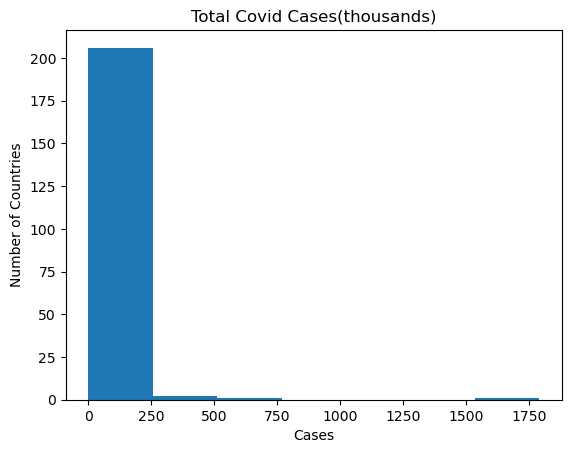

In [39]:
plt.hist(covidtotalsonly['total_cases']/1000, bins = 7)
plt.title('Total Covid Cases(thousands)')
plt.xlabel('Cases')
plt.ylabel('Number of Countries')
plt.show()

- 코로나 19 데이터에 로그 변환 수행 >> 총 사례의 로그 변환 히스토그램 확인

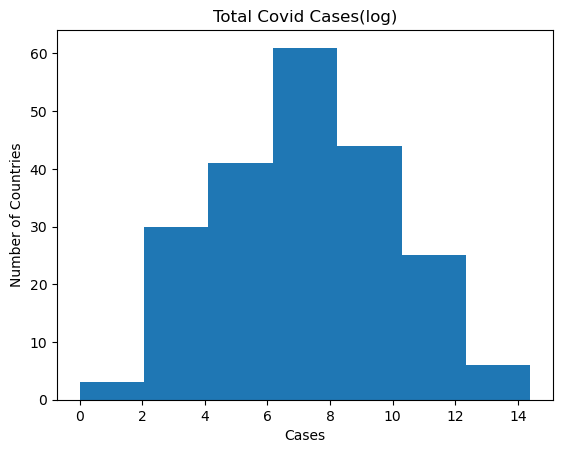

In [40]:
covidlogs =covidtotalsonly.copy()
for col in covidtotalsonly.columns[1:]:
    covidlogs[col] = np.log1p(covidlogs[col])
plt.hist(covidlogs['total_cases'], bins = 7)
plt.title('Total Covid Cases(log)')
plt.xlabel('Cases')
plt.ylabel('Number of Countries')
plt.show()